In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import shutil
import csv
import statistics


# Initialize an empty list to store the results
results = []

# Assuming you have the values for each grade already calculated
# Example values, replace with actual data
grades = [0, 1, 2, 3, 4]

l_movs = []
l_modes = []
l_means = []
l_meds = []
l_stds = []

r_movs = []
r_modes = []
r_means = []
r_meds = []
r_stds = []

**joint Edges values**

In [2]:
def joint_edges_values(img, interval, image_size=224):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint8:
        raise ValueError("Image must be a NumPy array of type uint8")
    if interval <= 0 or not isinstance(interval, int):
        raise ValueError("Interval must be a positive integer")

    # col_indices hold indices of columns at specific intervals along image row/width
    col_indices = np.arange(0, image_size, interval)
    # initialize upper row values to 1/3rd of image height
    upper_edge_rvals = np.full(len(col_indices), int(image_size/4), dtype=np.uint8)
    # initialize lower row values to 3/4th of image height
    lower_edge_rvals = np.full(len(col_indices), int(image_size*3/4), dtype=np.uint8)

    for i, c in enumerate(col_indices):
        up_start, low_start = int(image_size/4), int(image_size*3/4)
        col = img[:, c]
        col = col[up_start:low_start]
        col_max, col_min, col_std = col.max(), col.min(), col.std()
        col_thresh = col_min + int(col_std) # improvement
        
        up_flag = low_flag = False
        upper_r, lower_r = up_start, low_start
        
        while upper_r < low_start:
            # need to improve
            if img[upper_r, c] > (col_max - col_std):
                upper_edge_rvals[i] = upper_r
                break
            upper_r += 1
                    
        while lower_r > up_start:       
            if img[lower_r, c] > (col_max - col_std):
                lower_edge_rvals[i] = lower_r
                break
            lower_r -= 1
        
    return upper_edge_rvals, lower_edge_rvals

## Sobel Operator

In [3]:
def Sobel2(img):
    sobel_x = cv2.Sobel(img, cv2.CV_64F,1, 0, ksize =3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize =3)
    
    sobel_mag = np.sqrt(sobel_x**2+sobel_y**2)
    
    sobel_mag = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    return sobel_mag



# Define the function to shine the edges
def shine_edges(img):
    # Apply edge detection (Canny)
#     edges = cv2.Canny(img, 150, 200)
    
    # Find contours in the edges image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask to draw the contours
    mask = np.zeros_like(img)
    
    # Draw the contours on the mask
    cv2.drawContours(mask, contours, -1, (255), 1)
    
    # Define the middle region coordinates
    top = img.shape[0] // 4
    bottom = 3 * img.shape[0] // 4
    
    # Create a mask for the middle region
    middle_mask = np.zeros_like(img)
    middle_mask[top:bottom, :] = mask[top:bottom, :]
    
    # Set the pixel values along the detected edges to 255 in the original image
    img[middle_mask > 0] = 255
    
    return img

process single image

In [4]:

def most_occuring(roi):
    max_value = roi[0]
    max_count = 1
    current_value = roi[0]
    current_count = 1

    for i in range(1, len(roi)):
        if roi[i] == current_value:
            current_count += 1
        else:
            if current_count > max_count:
                max_value = current_value
                max_count = current_count
            current_value = roi[i]
            current_count = 1

    if current_count > max_count:
        max_value = current_value

    return max_value if max_count > 1 else 224



def process_image(img_path):
#     print(img_path)
    img = Image.open(img_path)
    img = np.array(img)
    original_img = img
    
    
#     img = preprocess(img)

    trials = 1
    for i in range(trials):
        img = Sobel2(img)

    img = np.array(np.uint8(img))
    
#     img = shine_edges(img)


    interval = 4
    # calculate upper and lower edges for this image
    upper_edge_row_vals, lower_edge_row_vals = joint_edges_values(img, interval, img[0].size)

    joint_space_pixel_gap_sobel = lower_edge_row_vals - upper_edge_row_vals
    
    
    # these values are determined by observation
    left_range_start = 40
    left_range_end = 70
    right_range_start = 155
    right_range_end = 185

    '''
    fig, axs = plt.subplots(2, 3, figsize=(7, 7))

    # Plot the original image
    axs[0, 0].imshow(original_img, cmap='gray')
    axs[0, 0].set_title('Original Image')

    # Plot the Sobel image
    axs[0, 1].imshow(img, cmap='gray')
    axs[0, 1].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', s=1)
    axs[0, 1].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', s=1)
    axs[0, 1].set_title('Sobel Image')

    # Plot the image with edges from Sobel
    axs[0, 2].imshow(original_img, cmap='gray')
    axs[0, 2].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', s=1)
    axs[0, 2].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', s=1)
    axs[0, 2].set_title('Image with Sobel Edges')
    axs[0, 2].legend()
    
    # Draw vertical lines at specified intervals
    axs[0, 2].axvline(x=left_range_start, color='g', linestyle='--')
    axs[0, 2].axvline(x=left_range_end, color='g', linestyle='--')
    axs[0, 2].axvline(x=right_range_start, color='g', linestyle='--')
    axs[0, 2].axvline(x=right_range_end, color='g', linestyle='--')
    '''

    # Plot the image with edges from fastsam
    img_name = os.path.basename(img_path)  # This includes the .png extension
    img_label = os.path.basename(os.path.dirname(img_path))  # This gets the parent directory name
    img_label_int = int(img_label)
    
    fastsam_dir = "/kaggle/input/fast-segmented-knee-xray-dataset/fastsam_knee_xray_dataset/train"
    
    # Construct the path to the corresponding image in the fastsam directory
    fastsam_img_path = os.path.join(fastsam_dir, img_label, f's_{img_name}')
    try:
        fastsam_img = Image.open(fastsam_img_path)
    except IOError:
        return


    # Read the upper edge values from the CSV file
    upper_edge_df = pd.read_csv('/kaggle/input/edge-csv/upper_edge 2.csv')
    upper_edge_row = upper_edge_df[upper_edge_df.iloc[:, 1] == f's_{img_name}']
    upper_edge_row_vals = upper_edge_row.iloc[0, 2:].values if not upper_edge_row.empty else []
    for i in range(len(upper_edge_row_vals)):
        upper_edge_row_vals[i] -= (4 - img_label_int)



    # Read the lower edge values from the CSV file
    lower_edge_df = pd.read_csv('/kaggle/input/edge-csv/lower_edge 2.csv')
    lower_edge_row = lower_edge_df[lower_edge_df.iloc[:, 1] == f's_{img_name}']
    lower_edge_row_vals = lower_edge_row.iloc[0, 2:].values if not lower_edge_row.empty else []
    for i in range(len(lower_edge_row_vals)):
        lower_edge_row_vals[i] += (4 - img_label_int)


    
    joint_space_pixel_gap_fastsam = lower_edge_row_vals - upper_edge_row_vals
    

    '''
    # plot original image
    axs[1, 0].imshow(original_img, cmap='gray')
    axs[1, 0].set_title('Original Image')

    # Plot the fastsam image
    axs[1, 1].imshow(fastsam_img, cmap='gray')
    axs[1, 1].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', s=1)
    axs[1, 1].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', s=1)
    axs[1, 1].set_title('fastsam Image')
    
    
    # plot fastsam edges on original img
    lrs = left_range_start//interval
    lre = left_range_end//interval
    rrs = right_range_start//interval
    rre = right_range_end//interval
    
    axs[1, 2].imshow(original_img, cmap='gray')

    # Plot points within the specified ranges
    x_values = range(0, img.shape[1], interval)

    # Filter points for the left and right ranges
    left_x_values = x_values[lrs:lre]
    left_upper_vals = upper_edge_row_vals[lrs:lre]
    left_lower_vals = lower_edge_row_vals[lrs:lre]

    right_x_values = x_values[rrs:rre]
    right_upper_vals = upper_edge_row_vals[rrs:rre]
    right_lower_vals = lower_edge_row_vals[rrs:rre]

    
    # Scatter plot for the left range
    axs[1, 2].scatter(left_x_values, left_upper_vals, color='r', s=1)
    axs[1, 2].scatter(left_x_values, left_lower_vals, color='b', s=1)

    # Scatter plot for the right range
    axs[1, 2].scatter(right_x_values, right_upper_vals, color='r', s=1)
    axs[1, 2].scatter(right_x_values, right_lower_vals, color='b', s=1)

    axs[1, 2].set_title('Image with fastsam Edges')
    axs[1, 2].legend()

    # Draw vertical lines at specified intervals
    axs[1, 2].axvline(x=left_range_start, color='g', linestyle='--')
    axs[1, 2].axvline(x=left_range_end, color='g', linestyle='--')
    axs[1, 2].axvline(x=right_range_start, color='g', linestyle='--')
    axs[1, 2].axvline(x=right_range_end, color='g', linestyle='--')

    plt.tight_layout()
    plt.show()
    '''


    # show pixel gaps at specific interval along image-width
    left_range_start //= interval
    left_range_end //= interval
    right_range_start //= interval
    right_range_end //= interval
#     print(f"\nimg_width : {img.shape[0]}    interval : {interval}    total points : {img.shape[0]//interval}\n")
#     print(f"Sobel   {left_range_start}:{left_range_end} -> {joint_space_pixel_gap_sobel[left_range_start:left_range_end]}")
#     print(f"Sobel   {right_range_start}:{right_range_end} -> {joint_space_pixel_gap_sobel[right_range_start:right_range_end]}")
#     print(f"FastSAM {left_range_start}:{left_range_end} -> {joint_space_pixel_gap_fastsam[left_range_start:left_range_end]}")
#     print(f"FastSAM {right_range_start}:{right_range_end} -> {joint_space_pixel_gap_fastsam[right_range_start:right_range_end]}")
    
    
    # find left_gap and right_gap
    # separate left and right range
    left_roi = joint_space_pixel_gap_fastsam[left_range_start:left_range_end]
    right_roi = joint_space_pixel_gap_fastsam[right_range_start:right_range_end]
    
    # Convert all odd values to their next even value
#     left_roi = np.where(left_roi % 2 != 0, left_roi + 1, left_roi)
#     right_roi = np.where(right_roi % 2 != 0, right_roi + 1, right_roi)
    
    # Function to convert a number to the nearest multiple of 3
    def nearest_multiple_of_3(x):
        return round(x / 3) * 3

    # Convert all values to nearest multiple of 3
    left_roi = [nearest_multiple_of_3(x) for x in left_roi]
    right_roi = [nearest_multiple_of_3(x) for x in right_roi]

    # Calculate statistics for left_roi
    left_mean = np.mean(left_roi)
    left_median = np.median(left_roi)
    left_std_dev = np.std(left_roi)
    left_mov = most_occuring(left_roi)
    left_mode = statistics.mode(left_roi)

    # Calculate statistics for right_roi
    right_mean = np.mean(right_roi)
    right_median = np.median(right_roi)
    right_std_dev = np.std(right_roi)
    right_mov = most_occuring(right_roi)
    right_mode = statistics.mode(right_roi)

#     print("Left ROI Statistics")
#     print(f"Mean: {left_mean}")
#     print(f"Median: {left_median}")
#     print(f"Standard Deviation: {left_std_dev}")

#     print("Right ROI Statistics")
#     print(f"Mean: {right_mean}")
#     print(f"Median: {right_median}")
#     print(f"Standard Deviation: {right_std_dev}")

    return [left_mode, right_mode]

**Main**

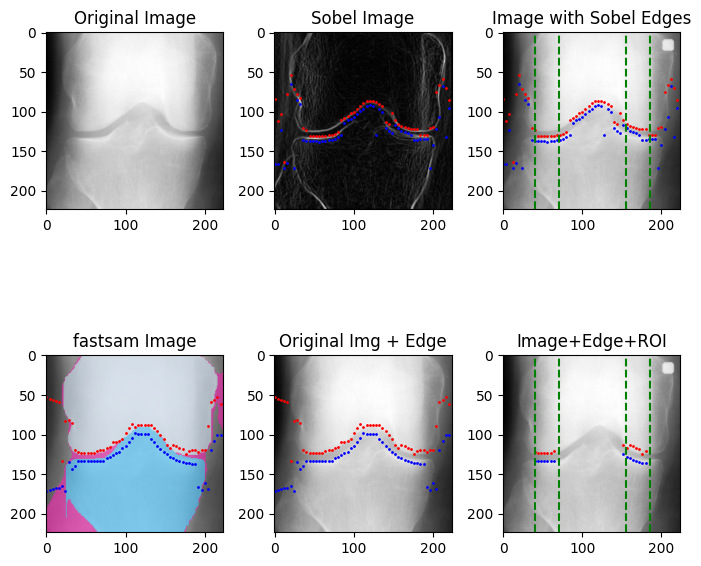


img_width : 224    interval : 4    total points : 56

Sobel   10:17 -> [14  6  6  6  7  6  6]
Sobel   38:46 -> [ 7  6  6  7  6  7 14 14]
FastSAM 10:17 -> [12 11 11 11 11 11 12]
FastSAM 38:46 -> [12 11 17 17 17 17 11 15]

Left ROI Statistics
Cmov: 224
Mode: 12
Mean: 12.0
Median: 12.0
Standard Deviation: 0.0

Right ROI Statistics
cmov: 18
Mode: 18
Mean: 15.375
Median: 16.5
Standard Deviation: 2.7810744326608736
[12, 18]


In [5]:
### view output for a single image 

def process_single_image(img_path):
    # Plot the image with edges from fastsam
    img_name = os.path.basename(img_path)  # This includes the .png extension
    img_label = os.path.basename(os.path.dirname(img_path))  # This gets the parent directory name
    img_label_int = int(img_label)
    img = Image.open(img_path)
    img = np.array(img)
    original_img = img
    
    
#     img = preprocess(img)

    trials = 1
    for i in range(trials):
        img = Sobel2(img)

    img = np.array(np.uint8(img))
    
#     img = shine_edges(img)


    interval = 4
    # calculate upper and lower edges for this image
    upper_edge_row_vals, lower_edge_row_vals = joint_edges_values(img, interval, img[0].size)
    for i in range(len(upper_edge_row_vals)):
        upper_edge_row_vals[i] -= (4 - img_label_int) #Offset
    for i in range(len(lower_edge_row_vals)):
        lower_edge_row_vals[i] += (4 - img_label_int) #Offset

    joint_space_pixel_gap_sobel = lower_edge_row_vals - upper_edge_row_vals
    
    
    # these values are determined by observation
    left_range_start = 40
    left_range_end = 70
    right_range_start = 155
    right_range_end = 185

    
    fig, axs = plt.subplots(2, 3, figsize=(7, 7))

    # Plot the original image
    axs[0, 0].imshow(original_img, cmap='gray')
    axs[0, 0].set_title('Original Image')

    # Plot the Sobel image
    axs[0, 1].imshow(img, cmap='gray')
    axs[0, 1].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', s=1)
    axs[0, 1].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', s=1)
    axs[0, 1].set_title('Sobel Image')

    # Plot the image with edges from Sobel
    axs[0, 2].imshow(original_img, cmap='gray')
    axs[0, 2].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', s=1)
    axs[0, 2].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', s=1)
    axs[0, 2].set_title('Image with Sobel Edges')
    axs[0, 2].legend()
    
    # Draw vertical lines at specified intervals
    axs[0, 2].axvline(x=left_range_start, color='g', linestyle='--')
    axs[0, 2].axvline(x=left_range_end, color='g', linestyle='--')
    axs[0, 2].axvline(x=right_range_start, color='g', linestyle='--')
    axs[0, 2].axvline(x=right_range_end, color='g', linestyle='--')
    
    
    fastsam_dir = "/kaggle/input/fast-segmented-knee-xray-dataset/fastsam_knee_xray_dataset/train"
    
    # Construct the path to the corresponding image in the fastsam directory
    fastsam_img_path = os.path.join(fastsam_dir, img_label, f's_{img_name}')
    try:
        fastsam_img = Image.open(fastsam_img_path)
    except IOError:
        return


    # Read the upper edge values from the CSV file
    upper_edge_df = pd.read_csv('/kaggle/input/edge-csv/upper_edge 2.csv')
    upper_edge_row = upper_edge_df[upper_edge_df.iloc[:, 1] == f's_{img_name}']
    upper_edge_row_vals = upper_edge_row.iloc[0, 2:].values if not upper_edge_row.empty else []
    for i in range(len(upper_edge_row_vals)):
        upper_edge_row_vals[i] -= (4 - img_label_int)



    # Read the lower edge values from the CSV file
    lower_edge_df = pd.read_csv('/kaggle/input/edge-csv/lower_edge 2.csv')
    lower_edge_row = lower_edge_df[lower_edge_df.iloc[:, 1] == f's_{img_name}']
    lower_edge_row_vals = lower_edge_row.iloc[0, 2:].values if not lower_edge_row.empty else []
    for i in range(len(lower_edge_row_vals)):
        lower_edge_row_vals[i] += (4 - img_label_int)


    
    joint_space_pixel_gap_fastsam = lower_edge_row_vals - upper_edge_row_vals
    


    # Plot the fastsam image
    axs[1, 0].imshow(fastsam_img, cmap='gray')
    axs[1, 0].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', s=1)
    axs[1, 0].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', s=1)
    axs[1, 0].set_title('fastsam Image')
    
    # Plot the original image with fastsam edges
    axs[1, 1].imshow(original_img, cmap='gray')
    axs[1, 1].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', s=1)
    axs[1, 1].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', s=1)
    axs[1, 1].set_title('Original Img + Edge')
    
    # plot fastsam edges on original img
    lrs = left_range_start//interval
    lre = left_range_end//interval
    rrs = right_range_start//interval
    rre = right_range_end//interval
    
    axs[1, 2].imshow(original_img, cmap='gray')

    # Plot points within the specified ranges
    x_values = range(0, img.shape[1], interval)

    # Filter points for the left and right ranges
    left_x_values = x_values[lrs:lre]
    left_upper_vals = upper_edge_row_vals[lrs:lre]
    left_lower_vals = lower_edge_row_vals[lrs:lre]

    right_x_values = x_values[rrs:rre]
    right_upper_vals = upper_edge_row_vals[rrs:rre]
    right_lower_vals = lower_edge_row_vals[rrs:rre]

    
    # Scatter plot for the left range
    axs[1, 2].scatter(left_x_values, left_upper_vals, color='r', s=1)
    axs[1, 2].scatter(left_x_values, left_lower_vals, color='b', s=1)

    # Scatter plot for the right range
    axs[1, 2].scatter(right_x_values, right_upper_vals, color='r', s=1)
    axs[1, 2].scatter(right_x_values, right_lower_vals, color='b', s=1)

    axs[1, 2].set_title('Image+Edge+ROI')
    axs[1, 2].legend()

    # Draw vertical lines at specified intervals
    axs[1, 2].axvline(x=left_range_start, color='g', linestyle='--')
    axs[1, 2].axvline(x=left_range_end, color='g', linestyle='--')
    axs[1, 2].axvline(x=right_range_start, color='g', linestyle='--')
    axs[1, 2].axvline(x=right_range_end, color='g', linestyle='--')

    plt.tight_layout()
    plt.show()
    


    # show pixel gaps at specific interval along image-width
    left_range_start //= interval
    left_range_end //= interval
    right_range_start //= interval
    right_range_end //= interval
    print(f"\nimg_width : {img.shape[0]}    interval : {interval}    total points : {img.shape[0]//interval}\n")
    print(f"Sobel   {left_range_start}:{left_range_end} -> {joint_space_pixel_gap_sobel[left_range_start:left_range_end]}")
    print(f"Sobel   {right_range_start}:{right_range_end} -> {joint_space_pixel_gap_sobel[right_range_start:right_range_end]}")
    print(f"FastSAM {left_range_start}:{left_range_end} -> {joint_space_pixel_gap_fastsam[left_range_start:left_range_end]}")
    print(f"FastSAM {right_range_start}:{right_range_end} -> {joint_space_pixel_gap_fastsam[right_range_start:right_range_end]}")
    
    
    # find left_gap and right_gap
    # separate left and right range
    left_roi = joint_space_pixel_gap_fastsam[left_range_start:left_range_end]
    right_roi = joint_space_pixel_gap_fastsam[right_range_start:right_range_end]
    
    
    # Function to convert a number to the nearest multiple of 3
    def nearest_multiple_of_3(x):
        return round(x / 3) * 3

    # Convert all values to nearest multiple of 3
    left_roi = [nearest_multiple_of_3(x) for x in left_roi]
    right_roi = [nearest_multiple_of_3(x) for x in right_roi]

    # Calculate statistics for left_roi
    left_mean = np.mean(left_roi)
    left_median = np.median(left_roi)
    left_std_dev = np.std(left_roi)
    left_mov = most_occuring(left_roi)
    left_mode = statistics.mode(left_roi)

    # Calculate statistics for right_roi
    right_mean = np.mean(right_roi)
    right_median = np.median(right_roi)
    right_std_dev = np.std(right_roi)
    right_mov = most_occuring(right_roi)
    right_mode = statistics.mode(right_roi)

    print("\nLeft ROI Statistics")
    print(f"Cmov: {left_mov}")
    print(f"Mode: {left_mode}")
    print(f"Mean: {left_mean}")
    print(f"Median: {left_median}")
    print(f"Standard Deviation: {left_std_dev}")

    print("\nRight ROI Statistics")
    print(f"cmov: {right_mov}")
    print(f"Mode: {right_mode}")
    print(f"Mean: {right_mean}")
    print(f"Median: {right_median}")
    print(f"Standard Deviation: {right_std_dev}")

    print([left_mode, right_mode])
    
    
    
# -------- show result for single image ------------
img_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/1/9000622R.png'

process_single_image(img_path)

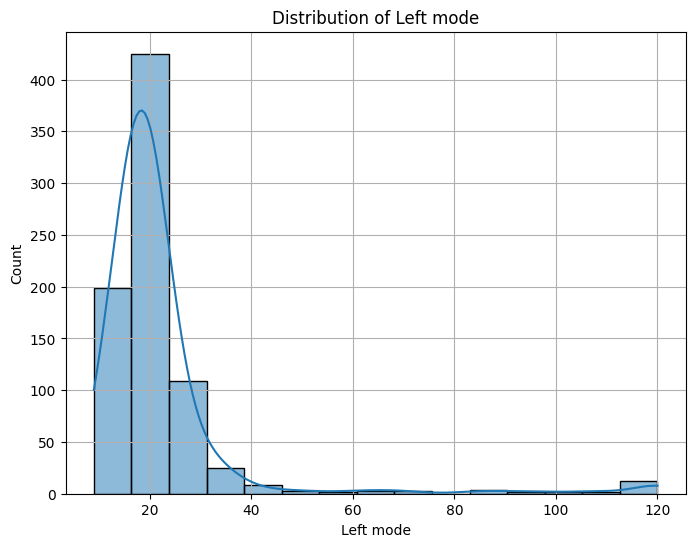

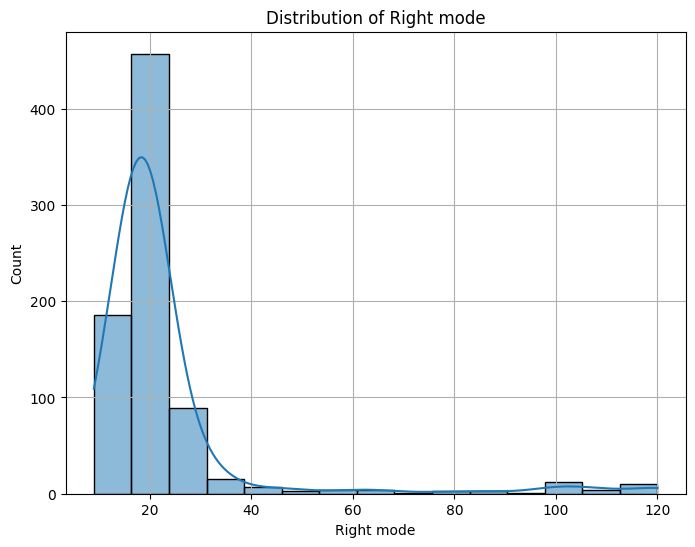

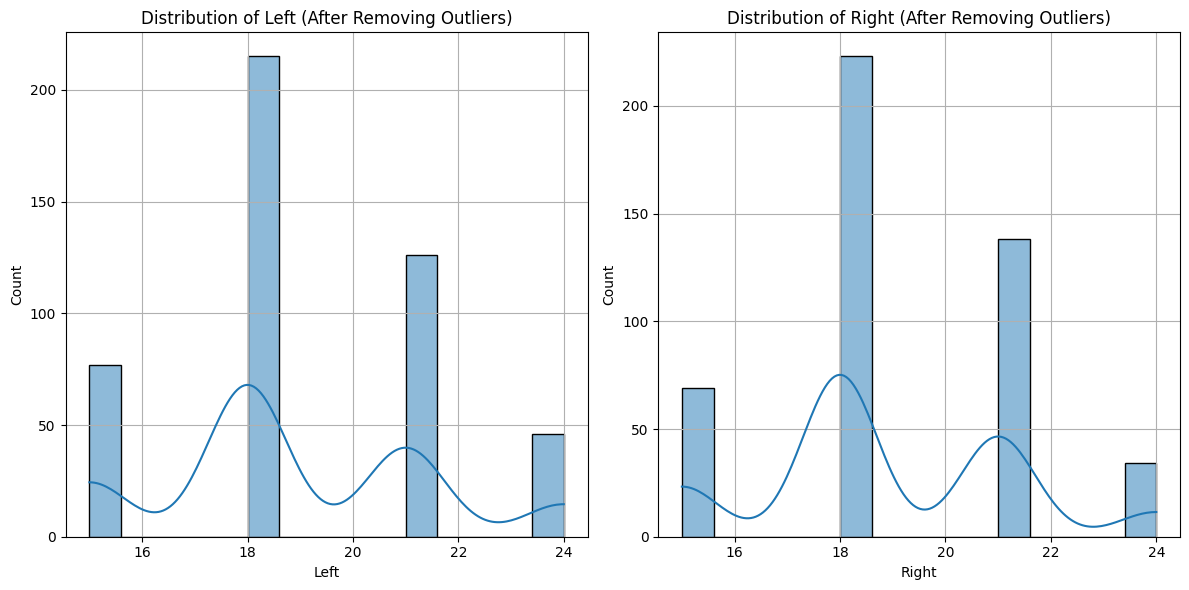


Central Tendencies for Left (after removing outliers):
CMOV: 18
Mode: 18
Mean: 18.911637931034484
Median: 18.0
Standard Deviation: 2.583676024570524

Central Tendencies for Right (after removing outliers):
CMOV: 18
Mode: 18
Mean: 18.885775862068964
Median: 18.0
Standard Deviation: 2.4224818603150142


In [6]:
#######  Label 0  ########

input_folder = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/0"
# Get the list of all image files in the input folder
image_files = os.listdir(input_folder)

output_csv = "roi_gaps_0.csv"
img_num = int(len(image_files) * 0.8)
# Initialize CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image_ID", "Left", "Right"])

    for i in range(img_num):
        img_path = os.path.join(input_folder, image_files[i])
        result = process_image(img_path)
        if result:
            img_name = image_files[i]
            writer.writerow([img_name, result[0], result[1]])
            
# Load the CSV file into a DataFrame
csv_file = '/kaggle/working/roi_gaps_0.csv'
df = pd.read_csv(csv_file)


# Plotting Left Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Left'], bins=15, kde=True)
plt.title('Distribution of Left mode')
plt.xlabel('Left mode')
plt.ylabel('Count')
plt.grid(True)
plt.show()


# Plotting Right Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Right'], bins=15, kde=True)
plt.title('Distribution of Right mode')
plt.xlabel('Right mode')
plt.ylabel('Count')
plt.grid(True)
plt.show()


### Denoising
## Finding most likely value of Left and Right joint space
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Calculate IQR for Left and Right
Q1_left = df['Left'].quantile(0.25)
Q3_left = df['Left'].quantile(0.75)
IQR_left = Q3_left - Q1_left

Q1_right = df['Right'].quantile(0.25)
Q3_right = df['Right'].quantile(0.75)
IQR_right = Q3_right - Q1_right

# Define threshold to filter outliers
threshold_left = 1.5 * IQR_left
threshold_right = 1.5 * IQR_right

# Filter rows based on thresholds
filtered_df = df[(df['Left'] >= Q1_left - threshold_left) & (df['Left'] <= Q3_left + threshold_left) &
                 (df['Right'] >= Q1_right - threshold_right) & (df['Right'] <= Q3_right + threshold_right)]

# Calculate central tendencies for filtered data
left_mov = most_occuring(list(filtered_df['Left']))
left_mode = statistics.mode(list(filtered_df['Left']))
left_mean = np.mean(filtered_df['Left'])
left_median = np.median(filtered_df['Left'])
left_std = np.std(filtered_df['Left'])

right_mov = most_occuring(list(filtered_df['Right']))
right_mode = statistics.mode(list(filtered_df['Right']))
right_mean = np.mean(filtered_df['Right'])
right_median = np.median(filtered_df['Right'])
right_std = np.std(filtered_df['Right'])


# Plotting histograms for Left and Right after denoising
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(filtered_df['Left'], bins=15, kde=True)
plt.title('Distribution of Left (After Removing Outliers)')
plt.xlabel('Left')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(filtered_df['Right'], bins=15, kde=True)
plt.title('Distribution of Right (After Removing Outliers)')
plt.xlabel('Right')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()



# Print the results
print("\nCentral Tendencies for Left (after removing outliers):")
print(f"CMOV: {left_mov}")
print(f"Mode: {left_mode}")
print(f"Mean: {left_mean}")
print(f"Median: {left_median}")
print(f"Standard Deviation: {left_std}")
print()

print("Central Tendencies for Right (after removing outliers):")
print(f"CMOV: {right_mov}")
print(f"Mode: {right_mode}")
print(f"Mean: {right_mean}")
print(f"Median: {right_median}")
print(f"Standard Deviation: {right_std}")

## Save the values
l_movs.append(left_mov)
l_modes.append(left_mode)
l_means.append(left_mean)
l_meds.append(left_median)
l_stds.append(left_std)

r_movs.append(right_mov)
r_modes.append(right_mode)
r_means.append(right_mean)
r_meds.append(right_median)
r_stds.append(right_std)

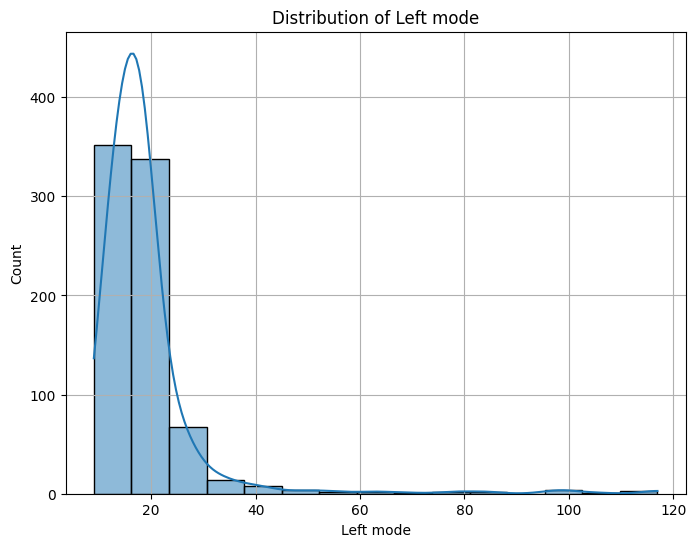

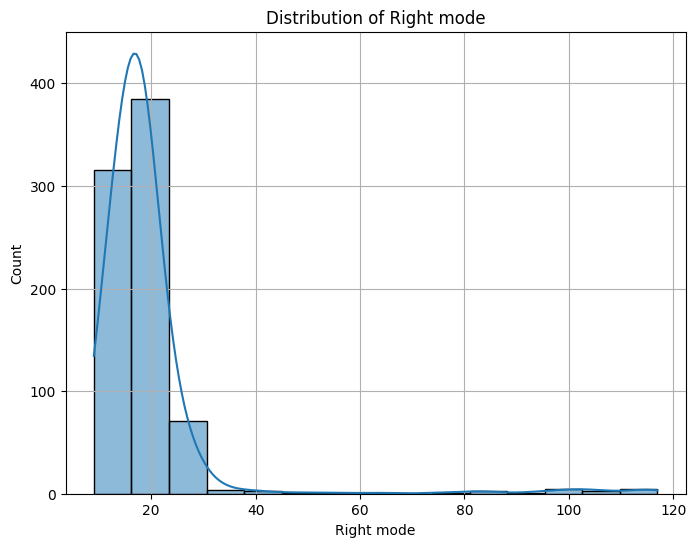

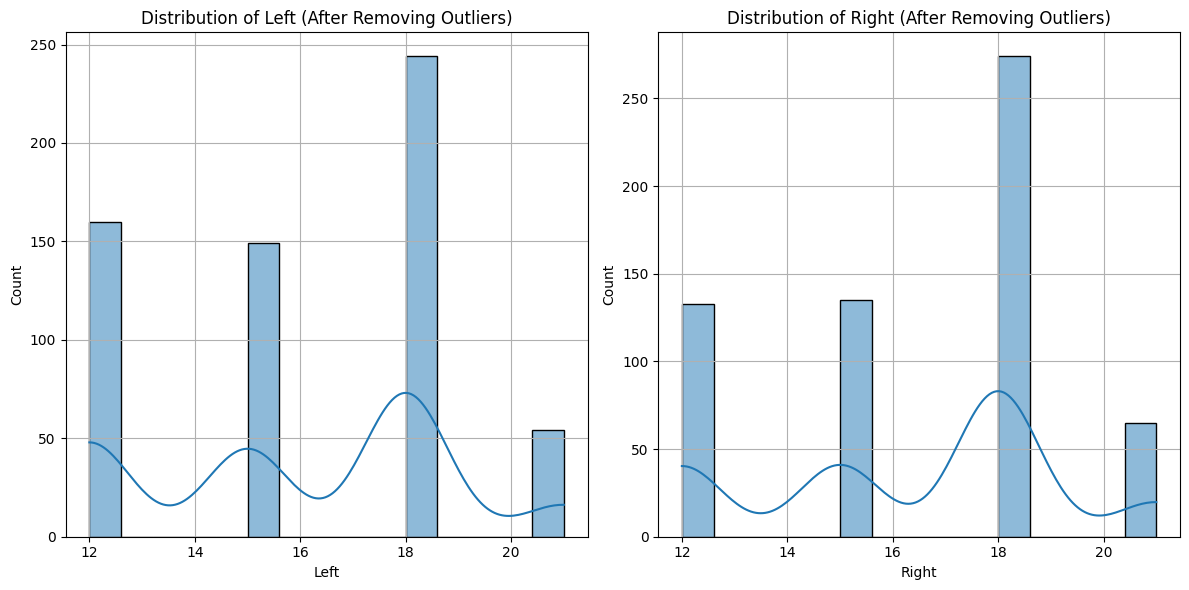


Central Tendencies for Left (after removing outliers):
CMOV: 18
Mode: 18
Mean: 15.948929159802306
Median: 15.0
Standard Deviation: 2.87963273444058

Central Tendencies for Right (after removing outliers):
CMOV: 18
Mode: 18
Mean: 16.339373970345964
Median: 18.0
Standard Deviation: 2.845294089347242


In [7]:
#######  Label 1  ########

input_folder = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/1"
# Get the list of all image files in the input folder
image_files = os.listdir(input_folder)

output_csv = "roi_gaps_1.csv"
img_num = int(len(image_files) * 0.8)
# Initialize CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image_ID", "Left", "Right"])

    for i in range(img_num):
        img_path = os.path.join(input_folder, image_files[i])
        result = process_image(img_path)
        if result:
            img_name = image_files[i]
            writer.writerow([img_name, result[0], result[1]])
            
# Load the CSV file into a DataFrame
csv_file = '/kaggle/working/roi_gaps_1.csv'
df = pd.read_csv(csv_file)


# Plotting Left Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Left'], bins=15, kde=True)
plt.title('Distribution of Left mode')
plt.xlabel('Left mode')
plt.ylabel('Count')
plt.grid(True)
plt.show()


# Plotting Right Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Right'], bins=15, kde=True)
plt.title('Distribution of Right mode')
plt.xlabel('Right mode')
plt.ylabel('Count')
plt.grid(True)
plt.show()


### Denoising
## Finding most likely value of Left and Right joint space
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Calculate IQR for Left and Right
Q1_left = df['Left'].quantile(0.25)
Q3_left = df['Left'].quantile(0.75)
IQR_left = Q3_left - Q1_left

Q1_right = df['Right'].quantile(0.25)
Q3_right = df['Right'].quantile(0.75)
IQR_right = Q3_right - Q1_right

# Define threshold to filter outliers
threshold_left = 1.5 * IQR_left
threshold_right = 1.5 * IQR_right

# Filter rows based on thresholds
filtered_df = df[(df['Left'] >= Q1_left - threshold_left) & (df['Left'] <= Q3_left + threshold_left) &
                 (df['Right'] >= Q1_right - threshold_right) & (df['Right'] <= Q3_right + threshold_right)]

# Calculate central tendencies for filtered data
left_mov = most_occuring(list(filtered_df['Left']))
left_mode = statistics.mode(list(filtered_df['Left']))
left_mean = np.mean(filtered_df['Left'])
left_median = np.median(filtered_df['Left'])
left_std = np.std(filtered_df['Left'])

right_mov = most_occuring(list(filtered_df['Right']))
right_mode = statistics.mode(list(filtered_df['Right']))
right_mean = np.mean(filtered_df['Right'])
right_median = np.median(filtered_df['Right'])
right_std = np.std(filtered_df['Right'])


# Plotting histograms for Left and Right after denoising
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(filtered_df['Left'], bins=15, kde=True)
plt.title('Distribution of Left (After Removing Outliers)')
plt.xlabel('Left')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(filtered_df['Right'], bins=15, kde=True)
plt.title('Distribution of Right (After Removing Outliers)')
plt.xlabel('Right')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()



# Print the results
print("\nCentral Tendencies for Left (after removing outliers):")
print(f"CMOV: {left_mov}")
print(f"Mode: {left_mode}")
print(f"Mean: {left_mean}")
print(f"Median: {left_median}")
print(f"Standard Deviation: {left_std}")
print()

print("Central Tendencies for Right (after removing outliers):")
print(f"CMOV: {right_mov}")
print(f"Mode: {right_mode}")
print(f"Mean: {right_mean}")
print(f"Median: {right_median}")
print(f"Standard Deviation: {right_std}")

## Save the values
l_movs.append(left_mov)
l_modes.append(left_mode)
l_means.append(left_mean)
l_meds.append(left_median)
l_stds.append(left_std)

r_movs.append(right_mov)
r_modes.append(right_mode)
r_means.append(right_mean)
r_meds.append(right_median)
r_stds.append(right_std)

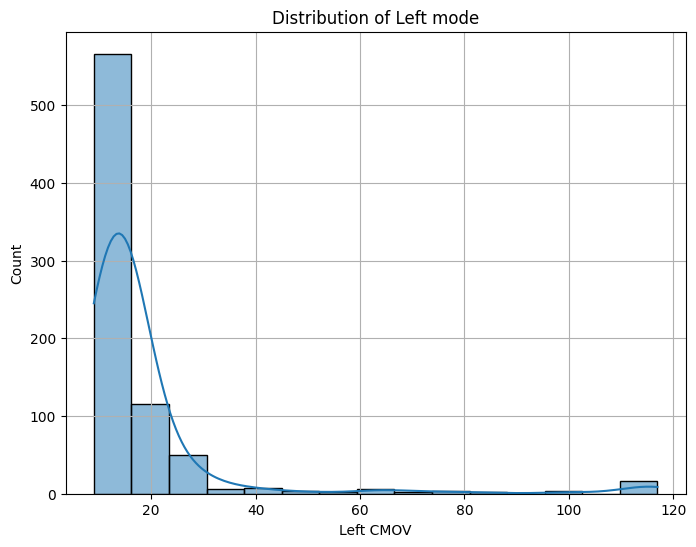

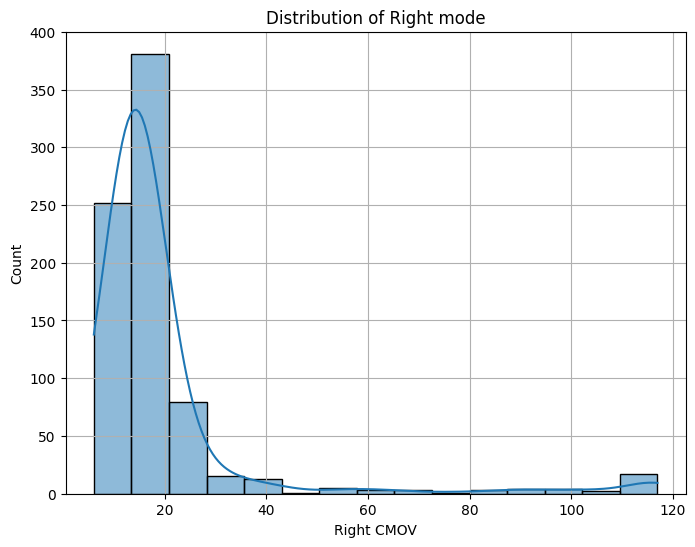

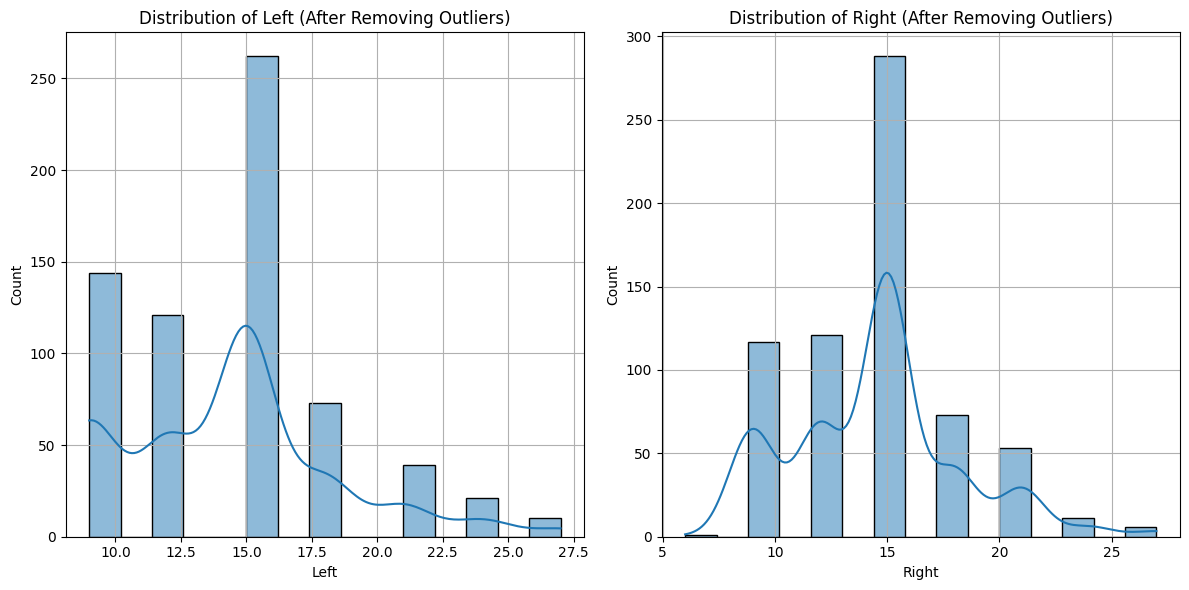


Central Tendencies for Left (after removing outliers):
CMOV: 15
Mode: 15
Mean: 14.305970149253731
Median: 15.0
Standard Deviation: 4.079851497041884

Central Tendencies for Right (after removing outliers):
CMOV: 15
Mode: 15
Mean: 14.453731343283582
Median: 15.0
Standard Deviation: 3.76592453052562


In [8]:
#######  Label 2  ########

input_folder = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/2"
# Get the list of all image files in the input folder
image_files = os.listdir(input_folder)

output_csv = "roi_gaps_2.csv"
img_num = int(len(image_files) * 0.8)
# Initialize CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image_ID", "Left", "Right"])

    for i in range(img_num):
        img_path = os.path.join(input_folder, image_files[i])
        result = process_image(img_path)
        if result:
            img_name = image_files[i]
            writer.writerow([img_name, result[0], result[1]])
            
# Load the CSV file into a DataFrame
csv_file = '/kaggle/working/roi_gaps_2.csv'
df = pd.read_csv(csv_file)


# Plotting Left Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Left'], bins=15, kde=True)
plt.title('Distribution of Left mode')
plt.xlabel('Left CMOV')
plt.ylabel('Count')
plt.grid(True)
plt.show()


# Plotting Right Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Right'], bins=15, kde=True)
plt.title('Distribution of Right mode')
plt.xlabel('Right CMOV')
plt.ylabel('Count')
plt.grid(True)
plt.show()


### Denoising
## Finding most likely value of Left and Right joint space
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Calculate IQR for Left and Right
Q1_left = df['Left'].quantile(0.25)
Q3_left = df['Left'].quantile(0.75)
IQR_left = Q3_left - Q1_left

Q1_right = df['Right'].quantile(0.25)
Q3_right = df['Right'].quantile(0.75)
IQR_right = Q3_right - Q1_right

# Define threshold to filter outliers
threshold_left = 1.5 * IQR_left
threshold_right = 1.5 * IQR_right

# Filter rows based on thresholds
filtered_df = df[(df['Left'] >= Q1_left - threshold_left) & (df['Left'] <= Q3_left + threshold_left) &
                 (df['Right'] >= Q1_right - threshold_right) & (df['Right'] <= Q3_right + threshold_right)]

# Calculate central tendencies for filtered data
left_mov = most_occuring(list(filtered_df['Left']))
left_mode = statistics.mode(list(filtered_df['Left']))
left_mean = np.mean(filtered_df['Left'])
left_median = np.median(filtered_df['Left'])
left_std = np.std(filtered_df['Left'])

right_mov = most_occuring(list(filtered_df['Right']))
right_mode = statistics.mode(list(filtered_df['Right']))
right_mean = np.mean(filtered_df['Right'])
right_median = np.median(filtered_df['Right'])
right_std = np.std(filtered_df['Right'])


# Plotting histograms for Left and Right after denoising
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(filtered_df['Left'], bins=15, kde=True)
plt.title('Distribution of Left (After Removing Outliers)')
plt.xlabel('Left')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(filtered_df['Right'], bins=15, kde=True)
plt.title('Distribution of Right (After Removing Outliers)')
plt.xlabel('Right')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()



# Print the results
print("\nCentral Tendencies for Left (after removing outliers):")
print(f"CMOV: {left_mov}")
print(f"Mode: {left_mode}")
print(f"Mean: {left_mean}")
print(f"Median: {left_median}")
print(f"Standard Deviation: {left_std}")
print()

print("Central Tendencies for Right (after removing outliers):")
print(f"CMOV: {right_mov}")
print(f"Mode: {right_mode}")
print(f"Mean: {right_mean}")
print(f"Median: {right_median}")
print(f"Standard Deviation: {right_std}")

## Save the values
l_movs.append(left_mov)
l_modes.append(left_mode)
l_means.append(left_mean)
l_meds.append(left_median)
l_stds.append(left_std)

r_movs.append(right_mov)
r_modes.append(right_mode)
r_means.append(right_mean)
r_meds.append(right_median)
r_stds.append(right_std)

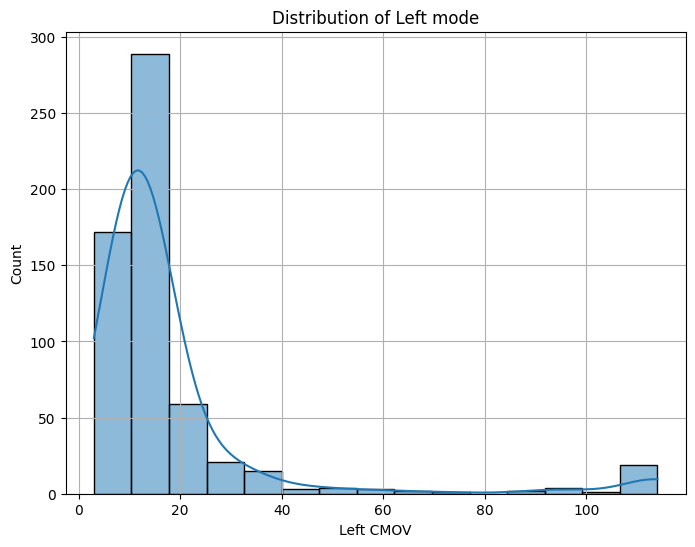

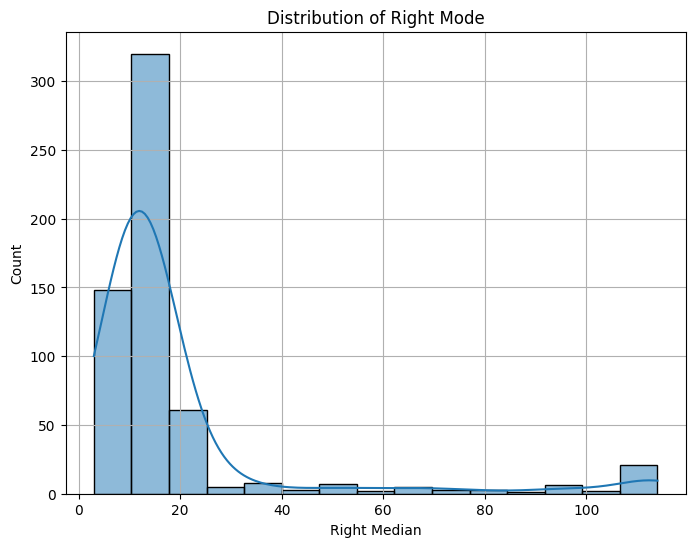

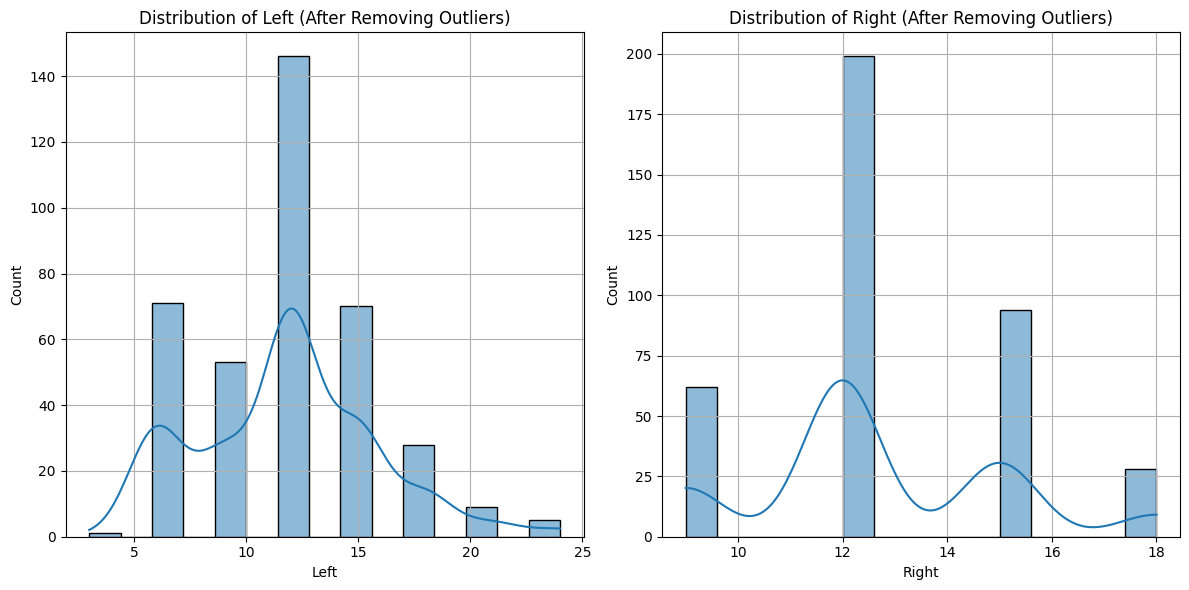


Central Tendencies for Left (after removing outliers):
CMOV: 12
Mode: 12
Mean: 11.804177545691905
Median: 12.0
Standard Deviation: 4.018986699229293

Central Tendencies for Right (after removing outliers):
CMOV: 12
Mode: 12
Mean: 12.689295039164492
Median: 12.0
Standard Deviation: 2.4129903604307095


In [9]:
#######  Label 3  ########

input_folder = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/3"
# Get the list of all image files in the input folder
image_files = os.listdir(input_folder)

output_csv = "roi_gaps_3.csv"
img_num = int(len(image_files) * 0.8)
# Initialize CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image_ID", "Left", "Right"])

    for i in range(img_num):
        img_path = os.path.join(input_folder, image_files[i])
        result = process_image(img_path)
        if result:
            img_name = image_files[i]
            writer.writerow([img_name, result[0], result[1]])
            
# Load the CSV file into a DataFrame
csv_file = '/kaggle/working/roi_gaps_3.csv'
df = pd.read_csv(csv_file)


# Plotting Left Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Left'], bins=15, kde=True)
plt.title('Distribution of Left mode')
plt.xlabel('Left CMOV')
plt.ylabel('Count')
plt.grid(True)
plt.show()


# Plotting Right Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Right'], bins=15, kde=True)
plt.title('Distribution of Right Mode')
plt.xlabel('Right Median')
plt.ylabel('Count')
plt.grid(True)
plt.show()


### Denoising
## Finding most likely value of Left and Right joint space
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Calculate IQR for Left and Right
Q1_left = df['Left'].quantile(0.25)
Q3_left = df['Left'].quantile(0.75)
IQR_left = Q3_left - Q1_left

Q1_right = df['Right'].quantile(0.25)
Q3_right = df['Right'].quantile(0.75)
IQR_right = Q3_right - Q1_right

# Define threshold to filter outliers
threshold_left = 1.5 * IQR_left
threshold_right = 1.5 * IQR_right

# Filter rows based on thresholds
filtered_df = df[(df['Left'] >= Q1_left - threshold_left) & (df['Left'] <= Q3_left + threshold_left) &
                 (df['Right'] >= Q1_right - threshold_right) & (df['Right'] <= Q3_right + threshold_right)]

# Calculate central tendencies for filtered data
left_mov = most_occuring(list(filtered_df['Left']))
left_mode = statistics.mode(list(filtered_df['Left']))
left_mean = np.mean(filtered_df['Left'])
left_median = np.median(filtered_df['Left'])
left_std = np.std(filtered_df['Left'])

right_mov = most_occuring(list(filtered_df['Right']))
right_mode = statistics.mode(list(filtered_df['Right']))
right_mean = np.mean(filtered_df['Right'])
right_median = np.median(filtered_df['Right'])
right_std = np.std(filtered_df['Right'])


# Plotting histograms for Left and Right after denoising
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(filtered_df['Left'], bins=15, kde=True)
plt.title('Distribution of Left (After Removing Outliers)')
plt.xlabel('Left')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(filtered_df['Right'], bins=15, kde=True)
plt.title('Distribution of Right (After Removing Outliers)')
plt.xlabel('Right')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()



# Print the results
print("\nCentral Tendencies for Left (after removing outliers):")
print(f"CMOV: {left_mov}")
print(f"Mode: {left_mode}")
print(f"Mean: {left_mean}")
print(f"Median: {left_median}")
print(f"Standard Deviation: {left_std}")
print()

print("Central Tendencies for Right (after removing outliers):")
print(f"CMOV: {right_mov}")
print(f"Mode: {right_mode}")
print(f"Mean: {right_mean}")
print(f"Median: {right_median}")
print(f"Standard Deviation: {right_std}")

## Save the values
l_movs.append(left_mov)
l_modes.append(left_mode)
l_means.append(left_mean)
l_meds.append(left_median)
l_stds.append(left_std)

r_movs.append(right_mov)
r_modes.append(right_mode)
r_means.append(right_mean)
r_meds.append(right_median)
r_stds.append(right_std)

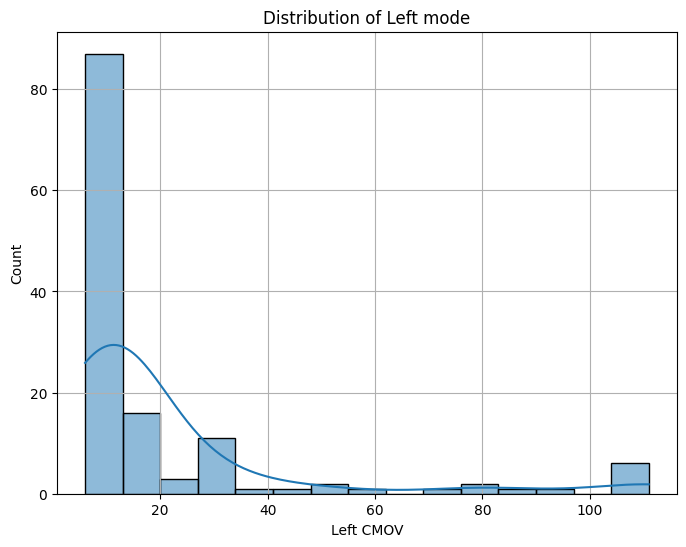

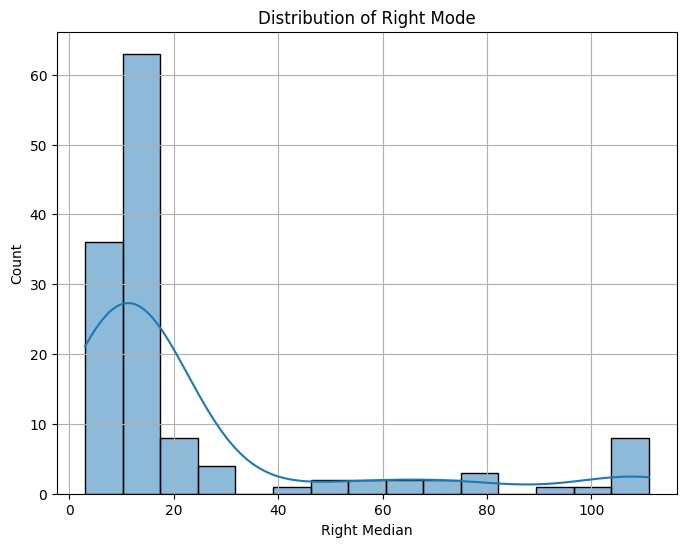

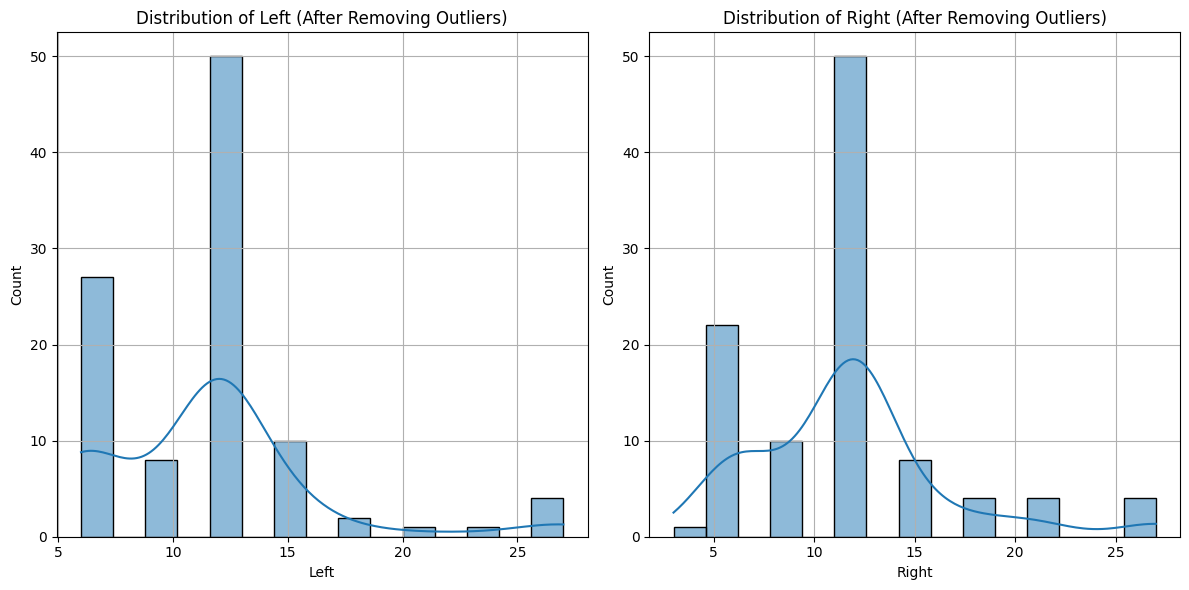


Central Tendencies for Left (after removing outliers):
CMOV: 12
Mode: 12
Mean: 11.388349514563107
Median: 12.0
Standard Deviation: 4.717727381359574

Central Tendencies for Right (after removing outliers):
CMOV: 12
Mode: 12
Mean: 11.737864077669903
Median: 12.0
Standard Deviation: 4.823005478496037


In [10]:
#######  Label 4  ########

input_folder = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/4"
# Get the list of all image files in the input folder
image_files = os.listdir(input_folder)

output_csv = "roi_gaps_4.csv"
img_num = int(len(image_files) * 0.8)
# Initialize CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image_ID", "Left", "Right"])

    for i in range(img_num):
        img_path = os.path.join(input_folder, image_files[i])
        result = process_image(img_path)
        if result:
            img_name = image_files[i]
            writer.writerow([img_name, result[0], result[1]])
            
# Load the CSV file into a DataFrame
csv_file = '/kaggle/working/roi_gaps_4.csv'
df = pd.read_csv(csv_file)


# Plotting Left Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Left'], bins=15, kde=True)
plt.title('Distribution of Left mode')
plt.xlabel('Left CMOV')
plt.ylabel('Count')
plt.grid(True)
plt.show()


# Plotting Right Median
plt.figure(figsize=(8, 6))
sns.histplot(df['Right'], bins=15, kde=True)
plt.title('Distribution of Right Mode')
plt.xlabel('Right Median')
plt.ylabel('Count')
plt.grid(True)
plt.show()


### Denoising
## Finding most likely value of Left and Right joint space
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Calculate IQR for Left and Right
Q1_left = df['Left'].quantile(0.25)
Q3_left = df['Left'].quantile(0.75)
IQR_left = Q3_left - Q1_left

Q1_right = df['Right'].quantile(0.25)
Q3_right = df['Right'].quantile(0.75)
IQR_right = Q3_right - Q1_right

# Define threshold to filter outliers
threshold_left = 1.5 * IQR_left
threshold_right = 1.5 * IQR_right

# Filter rows based on thresholds
filtered_df = df[(df['Left'] >= Q1_left - threshold_left) & (df['Left'] <= Q3_left + threshold_left) &
                 (df['Right'] >= Q1_right - threshold_right) & (df['Right'] <= Q3_right + threshold_right)]

# Calculate central tendencies for filtered data
left_mov = most_occuring(list(filtered_df['Left']))
left_mode = statistics.mode(list(filtered_df['Left']))
left_mean = np.mean(filtered_df['Left'])
left_median = np.median(filtered_df['Left'])
left_std = np.std(filtered_df['Left'])

right_mov = most_occuring(list(filtered_df['Right']))
right_mode = statistics.mode(list(filtered_df['Right']))
right_mean = np.mean(filtered_df['Right'])
right_median = np.median(filtered_df['Right'])
right_std = np.std(filtered_df['Right'])


# Plotting histograms for Left and Right after denoising
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(filtered_df['Left'], bins=15, kde=True)
plt.title('Distribution of Left (After Removing Outliers)')
plt.xlabel('Left')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(filtered_df['Right'], bins=15, kde=True)
plt.title('Distribution of Right (After Removing Outliers)')
plt.xlabel('Right')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()



# Print the results
print("\nCentral Tendencies for Left (after removing outliers):")
print(f"CMOV: {left_mov}")
print(f"Mode: {left_mode}")
print(f"Mean: {left_mean}")
print(f"Median: {left_median}")
print(f"Standard Deviation: {left_std}")
print()

print("Central Tendencies for Right (after removing outliers):")
print(f"CMOV: {right_mov}")
print(f"Mode: {right_mode}")
print(f"Mean: {right_mean}")
print(f"Median: {right_median}")
print(f"Standard Deviation: {right_std}")

## Save the values
l_movs.append(left_mov)
l_modes.append(left_mode)
l_means.append(left_mean)
l_meds.append(left_median)
l_stds.append(left_std)

r_movs.append(right_mov)
r_modes.append(right_mode)
r_means.append(right_mean)
r_meds.append(right_median)
r_stds.append(right_std)

# Save values to csv 

In [11]:
for grade, l_mov, l_mode, l_mean, l_med, l_std, r_mov, r_mode, r_mean, r_med, r_std in zip(grades, l_movs, l_modes, l_means, l_meds, l_stds, r_movs, r_modes, r_means, r_meds, r_stds):
    results.append({
        'grade': grade,
        'l_cmov': l_mov,
        'l_mode': l_mode,
        'l_mean': l_mean,
        'l_med': l_med,
        'l_std': l_std,
        'r_cmov': r_mov,
        'r_mode': r_mode,
        'r_mean': r_mean,
        'r_med': r_med,
        'r_std': r_std
    })

# Convert the list of results to a DataFrame
df = pd.DataFrame(results)

# Write the DataFrame to a CSV file
df.to_csv('joint_spaces.csv', index=False)

print("CSV file 'joint_spaces.csv' has been created successfully.")


# Display the DataFrame as a table
display(df)

CSV file 'joint_spaces.csv' has been created successfully.


,grade,l_cmov,l_mode,l_mean,l_med,l_std,r_cmov,r_mode,r_mean,r_med,r_std
0,0,18,18,18.911638,18.0,2.583676,18,18,18.885776,18.0,2.422482
1,1,18,18,15.948929,15.0,2.879633,18,18,16.339374,18.0,2.845294
2,2,15,15,14.305970,15.0,4.079851,15,15,14.453731,15.0,3.765925
3,3,12,12,11.804178,12.0,4.018987,12,12,12.689295,12.0,2.412990
4,4,12,12,11.388350,12.0,4.717727,12,12,11.737864,12.0,4.823005
